<a href="https://colab.research.google.com/github/Sachinanand99/automatic-music-generation/blob/main/LSTM%2BGWO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 33.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.7 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592286 sha256=fd8dc5c895c36e4674c3226793d501183667efb0349ad40b6d685134fe4a2a15
  Stored in directory: /root/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty_midi


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import collections
import numpy as np
import pandas as pd
import pretty_midi
import glob
import pathlib
import random
import os

from matplotlib import pyplot as plt


In [4]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

_SAMPLING_RATE = 16000


In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
data_dir = pathlib.Path('/content/drive/MyDrive/autogenmusic/maestro-v3.0.0')
filenames = glob.glob(str(data_dir / '**/*.mid*'), recursive=True)
print('Number of files:', len(filenames))


Number of files: 1276


In [7]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev_start)
        notes['duration'].append(end - start)
        prev_start = start

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

def notes_to_midi(notes: pd.DataFrame, out_file: str, instrument_name: str, velocity: int = 100) -> pretty_midi.PrettyMIDI:
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(instrument_name))
    prev_start = 0
    for i, note in notes.iterrows():
        start = float(prev_start + note['step'])
        end = float(start + note['duration'])
        note = pretty_midi.Note(velocity=velocity, pitch=int(note['pitch']), start=start, end=end)
        instrument.notes.append(note)
        prev_start = start
    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm


In [8]:
sample_file = filenames[1]
pm = pretty_midi.PrettyMIDI(sample_file)
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
raw_notes = midi_to_notes(sample_file)

In [9]:
num_files = 99
all_notes = []
for f in filenames[:num_files]:
    notes = midi_to_notes(f)
    all_notes.append(notes)

all_notes = pd.concat(all_notes)
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)

Number of notes parsed: 627111


In [10]:
def create_sequences(dataset: tf.data.Dataset, seq_length: int, vocab_size = 128) -> tf.data.Dataset:
    seq_length = seq_length+1
    windows = dataset.window(seq_length, shift=1, stride=1, drop_remainder=True)
    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    sequences = windows.flat_map(flatten)

    def scale_pitch(x):
        x = x/[vocab_size,1.0,1.0]
        return x

    def split_labels(sequences):
        inputs = sequences[:-1]
        labels_dense = sequences[-1]
        labels = {key:labels_dense[i] for i,key in enumerate(key_order)}
        return scale_pitch(inputs), labels

    return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)

batch_size = 64
buffer_size = n_notes - seq_length

train_ds = (seq_ds
    .shuffle(buffer_size)
    .batch(batch_size, drop_remainder=True)
    .repeat()
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

steps_per_epoch = (n_notes - seq_length) // batch_size


In [11]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
    mse = (y_true - y_pred) ** 2
    positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
    return tf.reduce_mean(mse + positive_pressure)

loss = {
    'pitch': SparseCategoricalCrossentropy(from_logits=True),
    'step': mse_with_positive_pressure,
    'duration': mse_with_positive_pressure,
}


In [12]:
class GreyWolfOptimizer:
    def __init__(self, fitness_fn, dim, search_space, num_wolves=5, max_iter=5):
        self.fitness_fn = fitness_fn
        self.dim = dim
        self.search_space = search_space
        self.num_wolves = num_wolves
        self.max_iter = max_iter

    def initialize_wolves(self):
        wolves = []
        for _ in range(self.num_wolves):
            wolf = [np.random.uniform(low, high) for low, high in self.search_space]
            wolves.append(wolf)
        return np.array(wolves)

    def optimize(self):
        wolves = self.initialize_wolves()
        fitness = np.array([self.fitness_fn(wolf) for wolf in wolves])

        for iter in range(self.max_iter):
            sorted_indices = np.argsort(fitness)
            wolves = wolves[sorted_indices]
            fitness = fitness[sorted_indices]

            alpha, beta, delta = wolves[0], wolves[1], wolves[2]

            a = 2 - iter * (2/self.max_iter)

            for i in range(self.num_wolves):
                for j in range(self.dim):
                    r1, r2 = np.random.rand(), np.random.rand()
                    A1 = 2 * a * r1 - a
                    C1 = 2 * r2
                    D_alpha = abs(C1 * alpha[j] - wolves[i][j])
                    X1 = alpha[j] - A1 * D_alpha

                    r1, r2 = np.random.rand(), np.random.rand()
                    A2 = 2 * a * r1 - a
                    C2 = 2 * r2
                    D_beta = abs(C2 * beta[j] - wolves[i][j])
                    X2 = beta[j] - A2 * D_beta

                    r1, r2 = np.random.rand(), np.random.rand()
                    A3 = 2 * a * r1 - a
                    C3 = 2 * r2
                    D_delta = abs(C3 * delta[j] - wolves[i][j])
                    X3 = delta[j] - A3 * D_delta

                    wolves[i][j] = (X1 + X2 + X3) / 3.0
                    wolves[i][j] = np.clip(wolves[i][j], self.search_space[j][0], self.search_space[j][1])

            fitness = np.array([self.fitness_fn(wolf) for wolf in wolves])
            print(f"Iteration {iter+1}, Best Fitness = {fitness[0]:.4f}")

        return wolves[0]


In [13]:
input_shape = (seq_length, 3)

def fitness(wolf):
    learning_rate = wolf[0]
    lstm_units = int(wolf[1])

    inputs = Input(input_shape)
    x = LSTM(lstm_units)(inputs)
    outputs = {
        'pitch': Dense(128, name='pitch')(x),
        'step': Dense(1, name='step')(x),
        'duration': Dense(1, name='duration')(x),
    }
    model = Model(inputs, outputs)
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(loss=loss, optimizer=optimizer)

    history = model.fit(
        train_ds,
        epochs=2,
        steps_per_epoch=steps_per_epoch//10,
        verbose=0
    )
    return history.history['loss'][-1]


In [ ]:
search_space = [
    (0.0001, 0.01),
    (64, 256),
]

gwo = GreyWolfOptimizer(fitness_fn=fitness, dim=2, search_space=search_space, num_wolves=5, max_iter=5)
best_params = gwo.optimize()

best_learning_rate, best_lstm_units = best_params
best_lstm_units = int(best_lstm_units)
print("Best Learning Rate:", best_learning_rate)
print("Best LSTM Units:", best_lstm_units)


Iteration 1, Best Fitness = 4.0513
Iteration 2, Best Fitness = 4.0368
Iteration 3, Best Fitness = 4.0413
Iteration 4, Best Fitness = 4.0399
Iteration 5, Best Fitness = 4.0474
Best Learning Rate: 0.008369083825636066
Best LSTM Units: 64


In [15]:
inputs = Input(input_shape)
x = LSTM(best_lstm_units)(inputs)

outputs = {
    'pitch': Dense(128, name='pitch')(x),
    'step': Dense(1, name='step')(x),
    'duration': Dense(1, name='duration')(x),
}

model = Model(inputs, outputs)

optimizer = Adam(learning_rate=best_learning_rate)

model.compile(loss=loss,
              loss_weights={'pitch': 0.05, 'step': 1.0, 'duration': 1.0},
              optimizer=optimizer)

model.summary()


Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30      │ (None, 25, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_30 (LSTM)      │ (None, 64)        │     17,408 │ input_layer_30[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration (Dense)    │ (None, 1)         │         65 │ lstm_30[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pitch (Dense)       │ (None, 128)       │      8,320 │ lstm_30[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ step (Dense)        │ (None, 1)         │         65 │ lstm_30[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,858 (101.01 KB)

 Trainable params: 25,858 (101.01 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/drive/MyDrive/autogenmusic/training_checkpoints/ckpt_{epoch}.weights.h5',
        save_weights_only=True
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True
    )
]

epochs = 50
history = model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks,
)


Epoch 1/50
9798/9798 ━━━━━━━━━━━━━━━━━━━━ 131s 6ms/step - duration_loss: 0.1017 - loss: 0.3471 - pitch_loss: 3.9846 - step_loss: 0.0461
Epoch 2/50
9798/9798 ━━━━━━━━━━━━━━━━━━━━ 134s 6ms/step - duration_loss: 0.0974 - loss: 0.3291 - pitch_loss: 3.8541 - step_loss: 0.0391
Epoch 3/50
9798/9798 ━━━━━━━━━━━━━━━━━━━━ 134s 6ms/step - duration_loss: 0.0925 - loss: 0.3201 - pitch_loss: 3.8014 - step_loss: 0.0375
Epoch 4/50
9798/9798 ━━━━━━━━━━━━━━━━━━━━ 134s 6ms/step - duration_loss: 0.0924 - loss: 0.3191 - pitch_loss: 3.7700 - step_loss: 0.0382
Epoch 5/50
9798/9798 ━━━━━━━━━━━━━━━━━━━━ 135s 6ms/step - duration_loss: 0.0919 - loss: 0.3207 - pitch_loss: 3.7558 - step_loss: 0.0410
Epoch 6/50
9798/9798 ━━━━━━━━━━━━━━━━━━━━ 133s 6ms/step - duration_loss: 0.0940 - loss: 0.3191 - pitch_loss: 3.7439 - step_loss: 0.0380
Epoch 7/50
9798/9798 ━━━━━━━━━━━━━━━━━━━━ 133s 6ms/step - duration_loss: 0.0913 - loss: 0.3152 - pitch_loss: 3.7290 - step_loss: 0.0375
Epoch 8/50
9798/9798 ━━━━━━━━━━━━━━━━━━━━ 136s 6

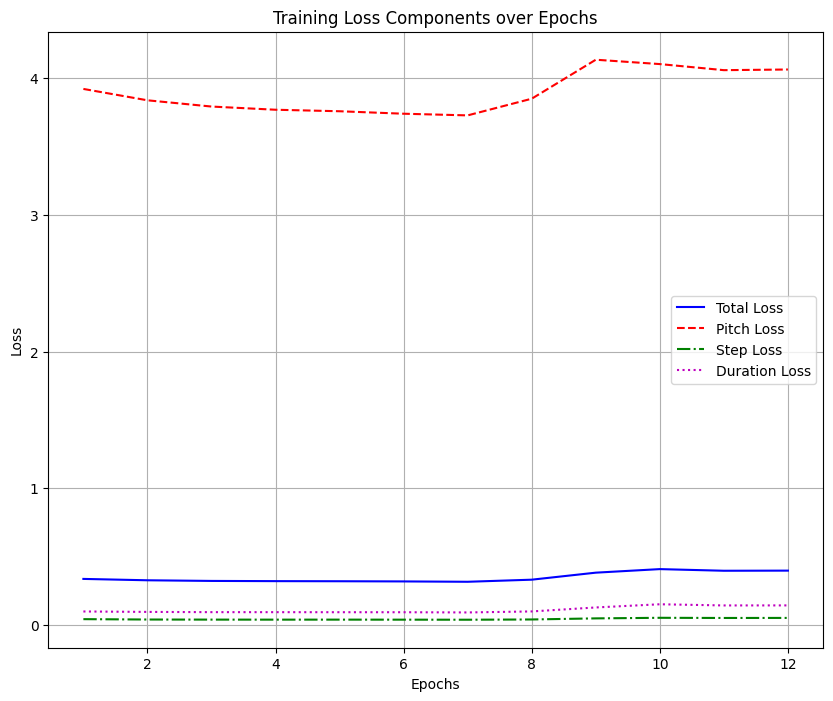

In [17]:
history_dict = history.history
epochs_range = range(1, len(history_dict['loss']) + 1)

plt.figure(figsize=(10, 8))
plt.plot(epochs_range, history_dict['loss'], 'b-', label='Total Loss')
plt.plot(epochs_range, history_dict['pitch_loss'], 'r--', label='Pitch Loss')
plt.plot(epochs_range, history_dict['step_loss'], 'g-.', label='Step Loss')
plt.plot(epochs_range, history_dict['duration_loss'], 'm:', label='Duration Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Components over Epochs')
plt.legend()
plt.grid(True)
plt.show()

model.save('/content/drive/MyDrive/autogenmusic/my_model.keras')


In [26]:
def predict_next_note(notes: np.ndarray, keras_model: tf.keras.Model,
                      temperature: float = 1.0) -> int:
    """Generates a note ID using a trained sequence model."""

    assert temperature > 0

    inputs = tf.expand_dims(notes, 0)

    predictions = keras_model.predict(inputs)
    pitch_logits = predictions['pitch']
    step = predictions['step']
    duration = predictions['duration']

    print(f"Predictions - Pitch logits: {pitch_logits}, Step: {step}, Duration: {duration}")

    pitch_logits /= temperature
    pitch = tf.random.categorical(pitch_logits, num_samples=1)
    pitch = tf.squeeze(pitch, axis=-1)

    step /= temperature
    duration /= temperature

    step = tf.maximum(0.1, step)
    duration = tf.maximum(0.1, duration)

    print(f"Adjusted - Pitch: {pitch}, Step: {step}, Duration: {duration}")

    return int(pitch), float(step), float(duration)

In [27]:
temperature = 2.0
num_predictions = 2000

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0

slowdown_factor = 2.0
for _ in range(num_predictions):
    pitch, step, duration = predict_next_note(input_notes, model, temperature)

    step *= slowdown_factor
    duration *= slowdown_factor

    start = prev_start + step
    end = start + duration

    input_note = (pitch, step, duration)
    generated_notes.append((*input_note, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_start = start
generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

generated_notes.head(10)


Streaming output truncated to the last 5000 lines.
   13.264582   13.371353   15.197086   15.754969   18.978443   17.178316
   20.285206   19.266235   18.61132    19.801498   13.896599   17.039148
    9.337278   12.515619   10.208553   -4.585519  -13.215771   -8.670837
  -12.018514  -24.292362  -23.871407  -24.236963  -24.130068  -23.946098
  -24.126938  -24.02247   -24.125486  -24.224773  -24.229713  -24.28126
  -23.807209  -24.075928  -23.791876  -23.74931   -24.246017  -23.923155
  -24.467018  -23.929033 ]], Step: [[0.10652003]], Duration: [[1.7407078]]
Adjusted - Pitch: [94], Step: [[0.1]], Duration: [[0.8703539]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predictions - Pitch logits: [[-23.90621   -23.678474  -24.1226    -23.880783  -24.108162  -23.88184
  -24.176443  -24.077742  -24.164793  -23.919994  -23.81267   -23.928726
  -24.18539   -24.013332  -24.041552  -23.621105  -23.985685  -23.983547
  -24.194078  -23.951626  -24.11505   -34.606895  -35.81386   -31.516111
  -10.0471115 -16

,pitch,step,duration,start,end
0,49,0.2,0.256045,0.2,0.456045
1,97,0.2,1.706108,0.4,2.106108
2,92,0.2,1.482636,0.6,2.082636
3,97,0.2,1.445446,0.8,2.245447
4,99,0.2,1.429506,1.0,2.429506
5,99,0.2,1.438654,1.2,2.638654
6,87,0.2,1.448166,1.4,2.848166
7,97,0.2,1.450641,1.6,3.050641
8,96,0.2,1.457538,1.8,3.257538
9,92,0.2,1.470443,2.0,3.470443


In [ ]:
FileLink(out_file)
out_file = '/content/drive/MyDrive/autogenmusic/output.midi'

out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
